In [1]:
# interpret model scores

# Modeling Our Data

---

## Imports and Functions

---

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# to remove
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [3]:
def qual_to_num(data, feature):
    '''
    Takes in DataFrame and column name containing string ratings
    replaces the ratings with numerical values
    
    Returns the updated DataFrame
    '''
    
    # ratings that appear in the dataset
    # and corresponding numerical value
    qual_conversion = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0, np.nan: 0}
    
    # convert to ratings using dictionary
    data[feature] = data[feature].apply(lambda x: qual_conversion[x])
    
    return data



def vif_df(df):
    '''
    Takes in a dataframe of numeric columns and computes
    the Variance Inflation Factor (VIF) for each variable.
    
    Returns a nx1 DataFrame of VIF scores.
    '''
    
    corr_features = df.columns
    
    # creats a list of VIF values, cycling through variables
    # to select as a target for scoring
    vif_values = [variance_inflation_factor(df.values, i) for i in range(len(corr_features))]
    
    # index scores with column names and sort from greatest to least
    vif = pd.DataFrame(vif_values,
                   index = corr_features,
                   columns = ['vif']).sort_values(by = 'vif', ascending = False)
    
    return vif



def setup_test():
    '''
    Generates a cleaned and feature engineered test dataset
    that matches the general structure of the cleaned train data.
    
    Returns the cleaned, feature engineered test data set.
    '''
    
    test_data = pd.read_csv('../datasets/test.csv')
    
    # initial features that were selected for the train dataset 
    test_features = ['MS Zoning', 'Lot Area', 'Land Contour', 'Land Slope', 'Neighborhood', 'Condition 1',
            'Bldg Type', 'House Style', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add',
           'Mas Vnr Type', 'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond',
           'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Kitchen Qual', 'Bedroom AbvGr',
           'Full Bath', 'Half Bath', 'Fireplaces', 'Fireplace Qu', 'BsmtFin SF 1', 'Bsmt Unf SF', '1st Flr SF', '2nd Flr SF', 'Sale Type',]
    
    
    test_data = test_data[test_features]
    
    # clean column names
    test_data.columns = [col.lower().replace(' ','_').replace('/','_') for col in test_data.columns]
    
    
    # converts descriptive rating to numerical
    test_data = qual_to_num(test_data, 'bsmt_qual')
    test_data = qual_to_num(test_data, 'bsmt_cond')
    test_data = qual_to_num(test_data, 'kitchen_qual')
    test_data = qual_to_num(test_data, 'exter_qual')
    test_data = qual_to_num(test_data, 'exter_cond')
    test_data = qual_to_num(test_data, 'fireplace_qu')
    
    # combines basment quality and condition ratings via multiplication
    test_data['bsmt_qual_cond'] = test_data['bsmt_qual'] * test_data['bsmt_cond']
    test_data.drop(columns = ['bsmt_qual', 'bsmt_cond'], inplace = True)
    
    test_data['qual_cond'] = test_data['overall_qual'] * test_data['overall_cond']
    test_data.drop(columns = ['overall_qual', 'overall_cond'], inplace = True)

    test_data['exter_qual_cond'] = test_data['exter_qual'] * test_data['exter_cond']
    test_data.drop(columns = ['exter_qual', 'exter_cond'], inplace = True)

    
    # combines fireplace count and quality rating via multiplication
    test_data['fireplaces_weighted'] = test_data['fireplaces'] * test_data['fireplace_qu']
    test_data.drop(columns = ['fireplaces', 'fireplace_qu'], inplace = True)
    
    # adds square feet (SF) measurements with weights:
    # 1*(Finished SF) + 0.5(Unfinished SF)
    test_data['bsmt_weighted_sf'] = test_data['bsmtfin_sf_1'] + 0.5*test_data['bsmt_unf_sf']
    test_data.drop(columns = ['bsmtfin_sf_1', 'bsmt_unf_sf'], inplace = True)
    
    # combines full bath and half bath into one column
    test_data['bath'] = test_data['full_bath'] + 0.5*test_data['half_bath']
    test_data.drop(columns = ['full_bath', 'half_bath'], inplace = True)
    
    #combines 1st floor and 2nd floor square feet areas
    test_data['sq_ft'] = test_data['1st_flr_sf'] + test_data['2nd_flr_sf']
    test_data.drop(columns = ['1st_flr_sf', '2nd_flr_sf'], inplace = True)
    
    # replace np.nan with most frequent value in the column 'None'
    test_data.loc[test_data['mas_vnr_type'].isna(), 'mas_vnr_type'] = 'None'
    
    return test_data


def dummify_train_test(train, numeric_cols, categ_cols):
    '''
    Takes a DataFrame with the desired features to model with,
    sets up a DataFrame of the test dataset with the same features,
    get_dummies is performed on both DataFrames, and then makes sure
    columns agree. If not, columns of zeros are added.
    
    Returns train and test DataFrames with desired features and
    categorical columns dummified and in identical order.
    '''
    
    # generate cleaned and feature engineered test dataframe
    test = setup_test()
    features = numeric_cols + categ_cols
    
    train_with_dummies = pd.get_dummies(train[features], columns = categ_cols, drop_first = True)
    test_with_dummies = pd.get_dummies(test[features], columns = categ_cols, drop_first = True)
    
    # save dummy column names from both train and test
    # to make sure both sets have identical column names/counts later
    both_columns_set = set(train_with_dummies.columns).union(set(test_with_dummies.columns))

    # for any column names not in set, add column with 0s
    for col in both_columns_set:
        if col not in train_with_dummies.columns:
            train_with_dummies[col] = 0
        if col not in test_with_dummies.columns:
            test_with_dummies[col] = 0
            
    # make sure column order agrees for train and test sets
    column_order = train_with_dummies.columns
    test_with_dummies = test_with_dummies[column_order]
    
    return train_with_dummies, test_with_dummies



def submit(kag_preds, attempt_num):
    '''
    Takes a set of Kaggle sale price predictions and an attempt number
    and creates a file in the datasets folder that is in the correct
    Kaggle submission format.
    '''
    
    # read test file for id column
    raw_house_test = pd.read_csv('../datasets/test.csv')
    kag_sub = {'Id': raw_house_test['Id'], 'SalePrice': kag_preds}
    
    # create a house id, sale price DataFrame
    kag_sub = pd.DataFrame(kag_sub)
    
    # file name format
    file_path = '../datasets/submission' + str(attempt_num) + '_john.csv'
    kag_sub.to_csv(file_path, index = False)

---

## Baseline Model

Before we try to create models to predict the saleprice we should have some idea of a baseline score. For linear regressions, the baseline score is the mean.

In [4]:
house = pd.read_csv('../datasets/cleaned_train.csv')

In [5]:
y = house['saleprice']

In [6]:
# creates an array with shape of y and filled with the mean
baseline_model = np.full_like(y, y.mean())

In [7]:
print(f'R squared: {metrics.r2_score(baseline_model, y)}')
print(f'RMSE: {metrics.mean_squared_error(baseline_model, y, squared = False)}')

R squared: 0.0
RMSE: 78668.04911315686


An R squared score of 0 is to be expected because by definition, R squared scores compare a model's performance against the mean. Our main metric for this project is Root Mean Squared Error (RMSE), which for the baseline model is 74,725. This means that if create a model whose RMSE score is lower, it would have been better to just guess the saleprice using the mean of the sale prices we already know.

---
## Take One

In [8]:
# select features
numeric_features = ['sq_ft', 'bsmt_weighted_sf']
categ_features = ['neighborhood', 'house_style']
features = numeric_features + categ_features

In [9]:
# get dummies on train and test datasets
# and make columns agree for modeling
train_dummy, test_dummy = dummify_train_test(house[features], numeric_features, categ_features)

In [10]:
# split training data into train and validation set
X_train, X_val, y_train, y_val = train_test_split(train_dummy, y, test_size = 0.3, random_state = 6)

In [11]:
# fit a linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# generate prediction sale prices on our train (yt_pred) and validation (yv_pred)
yt_pred =lr.predict(X_train)
yv_pred = lr.predict(X_val)

#### Model Scores

In [12]:
# print scores for our train split
print(f'Train Cross Validation: {cross_val_score(lr, X_train, y_train, cv = 5).mean()}\n')
print(f'Train R squared: {lr.score(X_train, y_train)}')
print(f'Train RMSE: {metrics.mean_squared_error(y_train, yt_pred, squared = False)}\n')

# print scores for our validation split
print(f'Validation R squared: {lr.score(X_val, y_val)}')
print(f'Validation RMSE: {metrics.mean_squared_error(y_val, yv_pred, squared = False)}')


Train Cross Validation: 0.8067105019900911

Train R squared: 0.8251691128036235
Train RMSE: 33390.172199297194

Validation R squared: 0.812873677471225
Validation RMSE: 32801.686192826564


R squared measures the percent of variability in the `saleprice` values that can be predicted by our choice of features. This first model's score of 82.5% suggests that `sq_ft`, `bsmt_weighted_sf`, `neighborhood`, and `house_style` collectively are strong indicators of a home's sale price in Ames, Iowa.

The fact that the model performed very closely on the validation data (in terms of both R squared and cross validation scores) informs us that our model does roughly as well on unseen data as with our training data. This is a great sign!

As for the RMSE score, it is an error score, so the lower the score value, the better. The RMSE scores of 33,390 and 32,801 both seem respectably low. This is further illustrated by how much smaller the error value is than the baseline model's RMSE score of 78,668.

#### Model Inference

In [13]:
# identifying columns get_dummies dropped
no_drop_dummies = pd.get_dummies(house[features], columns = categ_features)
set(no_drop_dummies.columns) - set(train_dummy)

{'house_style_1.5Fin', 'neighborhood_Blmngtn'}

We see that `1.5Fin` and `Blmngtn` were the baseline categories. This means that all of the coeficients express how much the home sale price changes compared to a one and a half story home in the Bloomington Heights neighborhood.

For example, the largest neighborhood coefficient of 87,412 means that the sale price of a 1.5-story home in Green Hills is typically 87,412 dollars more expensive relative to a 1.5-story home in Bloomington Heights, if we hold all other variables constant. On the otherhard, the coefficient of -3,454 suggests that under the same assumptions, a home in Gilbert is 3,454 dollars less expensive than one in Bloomington Heights.

The square feet coefficient of 83.32 means that for every additional square foot inside a home (not in the basement), the price of the home will increase by 83.32 dollars if we hold all else constant (again relative to a 1.5-story home in Bloomington Heights).

In [14]:
# creating a list of model coefficients with labels
coef = pd.Series(lr.coef_, index = train_dummy.columns)

In [15]:
# sorted neighborhood coefficients
coef[coef.index.str.contains('neighborhood')].sort_values(ascending = False)

neighborhood_GrnHill    87412.185188
neighborhood_StoneBr    79242.193035
neighborhood_NridgHt    64348.629130
neighborhood_Somerst    25142.463073
neighborhood_NoRidge    23729.045224
neighborhood_Timber     16359.014516
neighborhood_Veenker     5584.746526
neighborhood_CollgCr     2086.327620
neighborhood_Crawfor    -2712.311257
neighborhood_Gilbert    -3454.945615
neighborhood_Greens     -4529.804022
neighborhood_Blueste    -5995.783809
neighborhood_SawyerW   -16067.078698
neighborhood_ClearCr   -17797.661605
neighborhood_NPkVill   -23258.328839
neighborhood_Landmrk   -23554.343234
neighborhood_Mitchel   -26367.436433
neighborhood_BrDale    -28415.665993
neighborhood_NWAmes    -28508.775348
neighborhood_Sawyer    -30787.336349
neighborhood_BrkSide   -31577.838654
neighborhood_NAmes     -35992.636841
neighborhood_Edwards   -40130.195096
neighborhood_SWISU     -41207.488393
neighborhood_OldTown   -43430.219441
neighborhood_MeadowV   -51350.140388
neighborhood_IDOTRR    -51547.661201
d

In [16]:
# sorted house style coefficients
coef[coef.index.str.contains('house_style')].sort_values(ascending = False)

house_style_2.5Fin    54866.198343
house_style_SFoyer    28023.867095
house_style_SLvl      25641.654565
house_style_1.5Unf    24184.750001
house_style_1Story    17568.489380
house_style_2.5Unf    16879.759678
house_style_2Story     5982.290005
dtype: float64

In [17]:
coef[:2].sort_values(ascending = False)

sq_ft               83.328516
bsmt_weighted_sf    56.755196
dtype: float64

Of course these inferences only hold if our model meets necessary criterion.

#### Line Assumptions

We have already demonstrated linearity and multicollinearity of this model by inspecting correlation and VIF scores. It is fair to assume that the variables selected are independent.

What is left to check is the distribution of the residuals. That is, are the residuals normally distributed and do they form any patterns when compared against the true prices.

In [18]:
resids = y_train - yt_pred

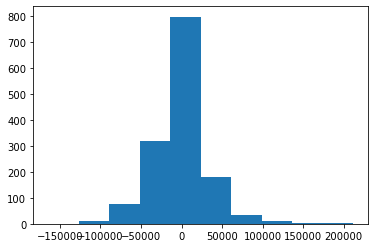

In [19]:
plt.hist(resids);

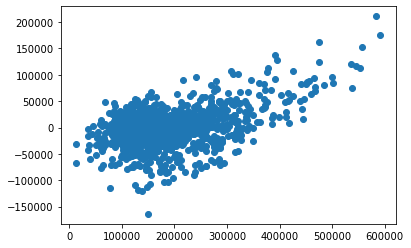

In [20]:
plt.scatter(y_train, resids);

Although not perfectly normal, the distribution of residual values do resemble a normal distribution. The scatterplot of y-values vs residuals does show a little bit of clustering, but it has a generally good shape for residual values. Together this means that the inferences above are fairly trustworthy.

---
## Take Two

When we selected the features for our first linear model, one of our primary goals was to keep the VIF score low. During that process, we ruled out several features that seemed somewhat helpful for predicting the `saleprice` because they pushed the VIF scores a little too high. Let us take a look at some of these features that did not dramatically increase VIF scores, namely:

- `garage_area`
- `wood_deck_sf`
- `open_porch_sf`
- `fireplace_weighted_sf`

The last three features do not seem the most helpful, so we may be modeling a bit more moise with their inclusion. Let us continue and see the results anyways.

In [21]:
# the VIF scores are higher, but not extraordinarily high
vif_df(house[['sq_ft', 'garage_area', 'wood_deck_sf', 'open_porch_sf', 'fireplaces_weighted']])

,vif
sq_ft,8.865599
garage_area,7.384474
fireplaces_weighted,2.273468
wood_deck_sf,1.737158
open_porch_sf,1.691571


Now we just repeat our model building steps, nearly verbatum.

In [22]:
# select features
numeric_features = ['sq_ft', 'garage_area', 'wood_deck_sf', 'open_porch_sf', 'fireplaces_weighted']
categoric_features = ['neighborhood', 'house_style']
features = numeric_features + categoric_features

In [23]:
# get dummies on train and test datasets
# and make columns agree for modeling
train_dummy, test_dummy = dummify_train_test(house[features], numeric_features, categ_features)

In [24]:
# split training data into train and validation set
X_train, X_val, y_train, y_val = train_test_split(train_dummy, y, test_size = 0.3, random_state = 6)

In [25]:
# fit a linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# generate prediction sale prices on our train (yt_pred) and validation (yv_pred)
yt_pred = lr.predict(X_train)
yv_pred = lr.predict(X_val)

In [26]:
# print scores for our train split
print(f'Train Cross Validation: {cross_val_score(lr, X_train, y_train, cv = 5).mean()}\n')
print(f'Train R squared: {lr.score(X_train, y_train)}')
print(f'Train RMSE: {metrics.mean_squared_error(y_train, yt_pred, squared = False)}\n')

# print scores for our validation split
print(f'Validation R squared: {lr.score(X_val, y_val)}')
print(f'Validation RMSE: {metrics.mean_squared_error(y_val, yv_pred, squared = False)}')

Train Cross Validation: 0.7995849695216942

Train R squared: 0.8182537391891903
Train RMSE: 34044.136281894214

Validation R squared: 0.8000526626067064
Validation RMSE: 33906.77939815086


We can see that the model score slightly decreases here, even with the additional features. This suggests the new features likely did not contribute much to the models ability to predict `saleprice`. This is unsurprising as it is hard to imagine paying much more money based on wood deck area, open porch area, or number of fireplaces. Let us remove these features in our next iteration and consider other choices.

---

## Take Three

Above we saw very little influence from including several features (wood deck area, open porch area, or number of fireplaces) with low VIF scores. Unfortunately, these features also had low correlation to `saleprice`

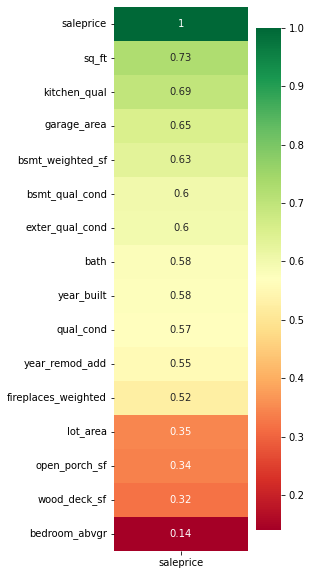

In [27]:
plt.figure(figsize = (3, 10))
corr = house.corr()[['saleprice']].sort_values(by = 'saleprice', ascending = False)
sns.heatmap(corr, cmap = 'RdYlGn', annot = True);

On the other hand, `garage_area` does have higher correlation to `saleprice`. Although we included it in our previous model that performed slightly worse, it may be worth keeping in our next attempt.

This time, let us also include `bsmt_weighted_sf` as it also has a higher correlation to `saleprice`. We will also include `kitchen_qual`, but as a categorical variable to dummify. This is probably more fitting than treating it numerically since a kitchen quality rating of 4 is not necessarily twice as good as a rating of 2, for example.


In [28]:
vif_df(house[['sq_ft', 'garage_area', 'bsmt_weighted_sf']])

,vif
garage_area,8.520796
sq_ft,8.348290
bsmt_weighted_sf,5.606644


One thing to note is that the VIF scores are a little high with these numeric features. We do not have many choices left for improving our model, so let us try these for now as see if we can obtain better predictions despite these VIF scores.

Now we build and score our model.

In [29]:
# select features
numeric_features = ['sq_ft', 'garage_area', 'bsmt_weighted_sf']
categ_features = ['neighborhood', 'house_style', 'kitchen_qual']
features = numeric_features + categ_features

In [30]:
# get dummies on train and test datasets
# and make columns agree for modeling
train_dummy, test_dummy = dummify_train_test(house[features], numeric_features, categ_features)

In [31]:
# split training data into train and validation set
X_train, X_val, y_train, y_val = train_test_split(train_dummy, y, test_size = 0.3, random_state = 6)

In [32]:
# fit a linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# generate prediction sale prices on our train (yt_pred) and validation (yv_pred)
yt_pred = lr.predict(X_train)
yv_pred = lr.predict(X_val)

In [33]:
# print scores for our train split
print(f'Train Cross Validation: {cross_val_score(lr, X_train, y_train, cv = 5).mean()}\n')
print(f'Train R squared: {lr.score(X_train, y_train)}')
print(f'Train RMSE: {metrics.mean_squared_error(y_train, yt_pred, squared = False)}\n')

# print scores for our validation split
print(f'Validation R squared: {lr.score(X_val, y_val)}')
print(f'Validation RMSE: {metrics.mean_squared_error(y_val, yv_pred, squared = False)}')

Train Cross Validation: 0.8534570872514353

Train R squared: 0.8676098959792825
Train RMSE: 29056.10122131043

Validation R squared: 0.8564313103254987
Validation RMSE: 28731.519610336578


With the inclusion of `garage_area`, `bsmt_weighted_sf` and `kitchen_qual`, the R squared scores are notably higher. Since we included `garage_area` in the previous model and did not see much of an increase in performance, it feels safe to say the higher scores are likely attributed to `bsmt_weighted_sf` and `kitchen_qual`.

Another thing to note is that our R squared scores are still very close to one another. This suggests that the model is performed comparably on unseen data. As is, this model would be fit for production.

Let us continue exploring models on additional features.

---

## Take Four

So far we have tried to keep the number of features low to avoid overfitting our models to the training data. This is especially important because we want our model to do well on predicting with unseen data, and overfitting can make our predictions worse.

Two models that are used to combat overfitting are Ridge and Lasso, which we plan to implement later. Let us add some more features we were on the cusp of including earlier. If this model is overfit, we can reduce this overfitting with Ridge and Lasso aftewards.

In [53]:
# select features
numeric_features = ['sq_ft', 'garage_area', 'bsmt_weighted_sf', 'year_built']
categ_features = ['neighborhood', 'house_style', 'kitchen_qual', 'qual_cond', 'exter_qual_cond']
features = numeric_features + categ_features

In [54]:
# get dummies on train and test datasets
# and make columns agree for modeling
train_dummy, test_dummy = dummify_train_test(house[features], numeric_features, categ_features)

In [55]:
# split training data into train and validation set
X_train, X_val, y_train, y_val = train_test_split(train_dummy, y, test_size = 0.3, random_state = 6)

In [56]:
# fit a linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# generate prediction sale prices on our train (yt_pred) and validation (yv_pred)
yt_pred = lr.predict(X_train)
yv_pred = lr.predict(X_val)

In [57]:
# print scores for our train split
print(f'Train Cross Validation: {cross_val_score(lr, X_train, y_train, cv = 5).mean()}\n')
print(f'Train R squared: {lr.score(X_train, y_train)}')
print(f'Train RMSE: {metrics.mean_squared_error(y_train, yt_pred, squared = False)}\n')

# print scores for our validation split
print(f'Validation R squared: {lr.score(X_val, y_val)}')
print(f'Validation RMSE: {metrics.mean_squared_error(y_val, yv_pred, squared = False)}')

Train Cross Validation: 0.8904960587650373

Train R squared: 0.914574607035238
Train RMSE: 23340.119254589645

Validation R squared: 0.887738294880876
Validation RMSE: 25406.482714142392


We see a decent improvement in our R squared scores and our RMSE scores are lower. As expected our model performed a little worse on our validation set, suggesting it is a little overfit. This gives us a chance to test Ridge and Lasso on the same set of features and see if we get any improvement.

---

## Take Five Ridge


We saw above that our model is slightly overfit. Let us see how Ridge performs on the same set of features. Because we are reusing the same features, we can reuse the same train-test-splits that were generated from those features.

In [58]:
# features already selected
# do not need to recreate X_train, X_val, y_train, y_val

# determining which choice of alpha is ideal
# for our Ridge model's penalty term
alphas = np.logspace(-5, 5, 200)
ridge_cv = RidgeCV(alphas = alphas, cv = 5)

One thing we must do differently, though, Ridge must be fit to normalized data. Let us scale the train and validation datasets.

In [59]:
ss = StandardScaler()

# scaling our train and val sets for Ridge
X_train_sc = ss.fit_transform(X_train)
X_val_sc = ss.transform(X_val)

Below we fit our Ridge model and look at the alpha hyperparameter it selected for the best fit.

In [60]:
ridge_cv.fit(X_train_sc, y_train);

In [61]:
ridge_cv.alpha_

42.97004704320844

Next we can save the `saleprice` predictions Ridge will make from each dataset.

In [62]:
yt_pred = ridge_cv.predict(X_train_sc)
yv_pred = ridge_cv.predict(X_val_sc)

In [63]:
# to keep runtime short, we cross validate with a Ridge model with the ideal choice of alpha - instead of running ridge_cv over again

# print train scores
print(f'Train Cross Validation: {cross_val_score(Ridge(alpha = ridge_cv.alpha_), X_train_sc, y_train, cv = 5).mean()}\n')
print(f'Train R squared: {ridge_cv.score(X_train_sc, y_train)}')
print(f'Train RMSE: {metrics.mean_squared_error(y_train, yt_pred, squared = False)}\n')

# print validation set scores
print(f'Validation R squared: {ridge_cv.score(X_val_sc, y_val)}')
print(f'Validation RMSE: {metrics.mean_squared_error(y_val, yv_pred, squared = False)}')

Train Cross Validation: 0.8920015793096547

Train R squared: 0.9140774915495748
Train RMSE: 23407.932250947517

Validation R squared: 0.8893470167997781
Validation RMSE: 25223.787069644084


Unforunately, our Ridge model does not seem to boost performance relative to the previous linear regression.

---

## Lasso

Let us now fit a Lasso model on the same set of features to see if this performs any better.

In [64]:
# features already selected
# do not need to recreate X_train, X_val, y_train, y_val

# determining which choice of alpha is ideal
# for our Lasso model's penalty term
alphas = np.logspace(-3, 5, 200)
lasso_cv = LassoCV(alphas = alphas, cv = 5)

Below we fit our Lasso model to our training dataset and check the alpha hyperparameter it selected as ideal.

In [65]:
#X_train_sc is already scaled correctly for our Ridge model
lasso_cv.fit(X_train_sc, y_train);

In [66]:
lasso_cv.alpha_

184.64249428955426

This value is a little higher than it was for Ridge, which seems expected since the alpha coefficient in Ridge is on squared terms and for Lasso it is on absolute valued terms (more compensation required).

Next we can save the `saleprice` predictions Lasso will make from each dataset.

In [67]:
yt_pred = lasso_cv.predict(X_train_sc)
yv_pred = lasso_cv.predict(X_val_sc)

In [68]:
# to keep runtime short, we cross validate with a Lasso model with the ideal choice of alpha - instead of running lasso_cv over again

# print train scores
print(f'Train Cross Validation: {cross_val_score(Lasso(alpha = lasso_cv.alpha_), X_train_sc, y_train, cv = 5).mean()}\n')
print(f'Train R squared: {ridge_cv.score(X_train_sc, y_train)}')
print(f'Train RMSE: {metrics.mean_squared_error(y_train, yt_pred, squared = False)}\n')

# print validation scores
print(f'Validation R squared: {ridge_cv.score(X_val_sc, y_val)}')
print(f'Validation RMSE: {metrics.mean_squared_error(y_val, yv_pred, squared = False)}')

Train Cross Validation: 0.89249108036683

Train R squared: 0.9140774915495748
Train RMSE: 23410.923805793936

Validation R squared: 0.8893470167997781
Validation RMSE: 25173.995930789133


Like Ridge, our Lasso model does not perform noticeably better than the linear model on the same features. We may be able to feel a little more confident that our model is not as overfit with either of our Ridge or Lasso results, but that is about the only benefit we get in this case.

One drawback is that we lose interpretability of our model. Since Ridge and Lasso only make sense to apply to scaled data, the coefficients derived from these models are in terms of unit changes to the normalized features. This is simply not clear.

---

## Kaggle Submission

Lastly, this project includes one submission to Kaggle. Let us do this below.

In [69]:
#best model from this batch of code, this will be our kaggle submission
#test_dummy was made in model 4's dummify function

# lasso on performs on scaled data, must scale test data
X_test_sc = ss.transform(test_dummy)
kag_pred = lasso_cv.predict(X_test_sc)

# function to generate submission file
submit(kag_pred, 1) # kaggle submission scored 29,051